In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [2]:
results = pd.read_csv("test_results/pg_optimisations_tpch_queries_test_results.csv") 
test_name = "postgres_optimisations"

results = results.rename(columns={"Average": "Mean"})

In [3]:
print(len(results))
results.head()

154


,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs
0,SQL,1,Postgres,Query 1,5.68,True,Yes,"[5.7111523151397705, 5.535632610321045, 5.7905..."
1,Pandas,1,Pandas Baseline,Query 1,1.69,True,Yes,"[2.1982407569885254, 1.5990703105926514, 1.589..."
2,Pandas,1,Pandas 1,Query 1,1.66,True,Yes,"[2.107384443283081, 1.5789008140563965, 1.5716..."
3,Pandas,1,Pandas 2,Query 1,1.66,True,Yes,"[2.1031992435455322, 1.5782842636108398, 1.571..."
4,Pandas,1,Pandas 3,Query 1,1.66,True,Yes,"[2.1038637161254883, 1.5735630989074707, 1.573..."


In [4]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

154


In [5]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

results['Median'] = results.apply(lambda row: statistics.median(sorted(row['Runs'])), axis = 1)

def ignore_first_mean(runs):
    return statistics.mean(runs[1:])

results['Mean'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]

In [6]:
def process_optim_type(name):
    split_name = name.split(" ")
    if split_name[-1] == "Baseline":
        return "B"
    else:
        return str(split_name[-1]).strip()

results = results[results["Data Type"] != "SQL"]
results['Optimisation'] = results.apply(lambda row : process_optim_type(row['Query Name']), axis = 1)
#results

In [7]:
results = results.sort_values(by=['Query Number', 'Query Name'], ascending=[True, True])
results.head(15)

,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs,Median,Query Type,Optimisation
2,Pandas,1,Pandas 1,1,1.569200,True,Yes,"[2.107384443283081, 1.5789008140563965, 1.5716...",1.570578,Pandas 1,1
6,Pandas,1,Pandas 1+2+3,1,1.580550,True,Yes,"[2.108522415161133, 1.5792231559753418, 1.5838...",1.581571,Pandas 1+2+3,1+2+3
3,Pandas,1,Pandas 2,1,1.575178,True,Yes,"[2.1031992435455322, 1.5782842636108398, 1.571...",1.577093,Pandas 2,2
5,Pandas,1,Pandas 2+3,1,1.577717,True,Yes,"[2.1144676208496094, 1.5778415203094482, 1.578...",1.577944,Pandas 2+3,2+3
4,Pandas,1,Pandas 3,1,1.572890,True,Yes,"[2.1038637161254883, 1.5735630989074707, 1.573...",1.573573,Pandas 3,3
1,Pandas,1,Pandas Baseline,1,1.584839,True,Yes,"[2.1982407569885254, 1.5990703105926514, 1.589...",1.585860,Pandas Baseline,B
9,Pandas,1,Pandas 1,2,0.601272,True,Yes,"[0.759354829788208, 0.6016073226928711, 0.6004...",0.601660,Pandas 1,1
13,Pandas,1,Pandas 1+2+3,2,0.599850,True,Yes,"[0.7450675964355469, 0.5985987186431885, 0.599...",0.599976,Pandas 1+2+3,1+2+3
10,Pandas,1,Pandas 2,2,0.597881,True,Yes,"[0.7516725063323975, 0.6003029346466064, 0.598...",0.598052,Pandas 2,2
12,Pandas,1,Pandas 2+3,2,0.600443,True,Yes,"[0.761746883392334, 0.6039376258850098, 0.6003...",0.600525,Pandas 2+3,2+3


In [8]:
#results
unique_query_numbers = list(results["Query Number"].unique())
q_scores_in_order = []
#unique_query_numbers
for q_num in unique_query_numbers:
    baseline_score = float(results[(results["Query Number"] == q_num) & (results["Optimisation"] == "B")]["Mean"])
    query_scores = results[(results["Query Number"] == q_num) & (results["Optimisation"] != "B")]
    
    optimisation_types = list(query_scores["Optimisation"].unique())
    for optim in optimisation_types:
        current_q_score = query_scores[query_scores["Optimisation"] == optim]
        q_scores_in_order.append(float((baseline_score - current_q_score["Mean"]) / baseline_score))
    q_scores_in_order.append(0)
    
    #print(baseline_score)

In [9]:

results['Optim_improve'] = pd.Series(q_scores_in_order, index=results.index)
results.head(15)

,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs,Median,Query Type,Optimisation,Optim_improve
2,Pandas,1,Pandas 1,1,1.569200,True,Yes,"[2.107384443283081, 1.5789008140563965, 1.5716...",1.570578,Pandas 1,1,0.009868
6,Pandas,1,Pandas 1+2+3,1,1.580550,True,Yes,"[2.108522415161133, 1.5792231559753418, 1.5838...",1.581571,Pandas 1+2+3,1+2+3,0.002706
3,Pandas,1,Pandas 2,1,1.575178,True,Yes,"[2.1031992435455322, 1.5782842636108398, 1.571...",1.577093,Pandas 2,2,0.006096
5,Pandas,1,Pandas 2+3,1,1.577717,True,Yes,"[2.1144676208496094, 1.5778415203094482, 1.578...",1.577944,Pandas 2+3,2+3,0.004494
4,Pandas,1,Pandas 3,1,1.572890,True,Yes,"[2.1038637161254883, 1.5735630989074707, 1.573...",1.573573,Pandas 3,3,0.007540
1,Pandas,1,Pandas Baseline,1,1.584839,True,Yes,"[2.1982407569885254, 1.5990703105926514, 1.589...",1.585860,Pandas Baseline,B,0.000000
9,Pandas,1,Pandas 1,2,0.601272,True,Yes,"[0.759354829788208, 0.6016073226928711, 0.6004...",0.601660,Pandas 1,1,0.003658
13,Pandas,1,Pandas 1+2+3,2,0.599850,True,Yes,"[0.7450675964355469, 0.5985987186431885, 0.599...",0.599976,Pandas 1+2+3,1+2+3,0.006014
10,Pandas,1,Pandas 2,2,0.597881,True,Yes,"[0.7516725063323975, 0.6003029346466064, 0.598...",0.598052,Pandas 2,2,0.009278
12,Pandas,1,Pandas 2+3,2,0.600443,True,Yes,"[0.761746883392334, 0.6039376258850098, 0.6003...",0.600525,Pandas 2+3,2+3,0.005032


In [10]:
optim_results = results \
    .groupby(by=["Optimisation"]) \
    .agg(
            avg_percent_improve=("Optim_improve", "mean"),
        )

optim_results['Percentage Improvement'] = optim_results['avg_percent_improve'].apply(lambda x: x*100)
optim_results = optim_results.reset_index()
optim_results = optim_results[optim_results["Optimisation"] != "B"]
optim_results

,Optimisation,avg_percent_improve,Percentage Improvement
0,1,0.005518,0.551760
1,1+2+3,0.008430,0.842971
2,2,0.009849,0.984900
3,2+3,0.008501,0.850110
4,3,0.007430,0.743021


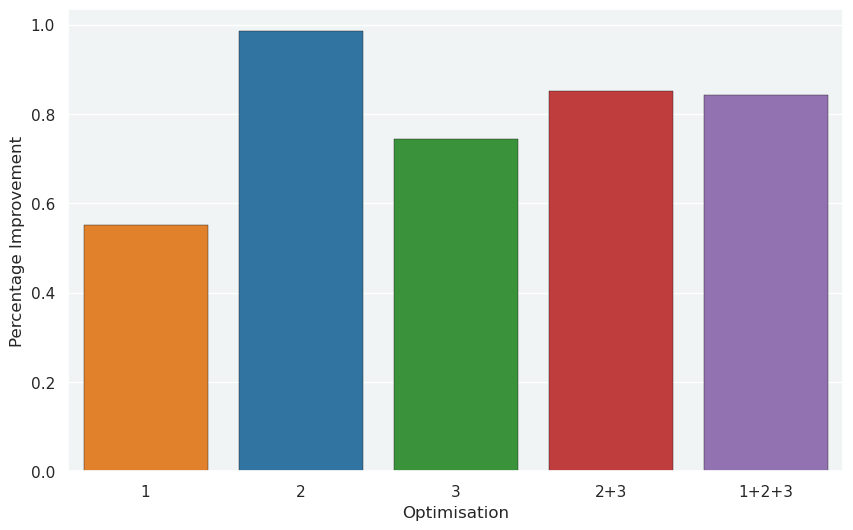

In [11]:
sns.set(rc={'figure.figsize':(10,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color})
plt.rcParams['patch.linewidth'] = 0.3
plt.rcParams['patch.edgecolor'] = 'k'

colors = ['tab:orange','tab:blue','tab:green', 'tab:red', 'tab:purple']
optim_order = ["1", "2", "3", "2+3", "1+2+3"]

ax = sns.barplot(data=optim_results, x='Optimisation', y='Percentage Improvement',
                 order=optim_order, palette=colors)

plt.savefig("analysis_results/" + str(test_name) + "_compare.pdf", bbox_inches="tight")
plt.show()